<a href="https://colab.research.google.com/github/oliverwsd/LSTM_AE/blob/master/LSTM_AE(abs_return).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2057]:
import json
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import urllib.request, json 

# _ preferences
plt.rcParams['figure.figsize'] = (30.0, 10.0)
plt.style.use('ggplot')
from keras import regularizers
from keras.optimizers       import Adam
from keras.models           import Sequential
from keras.layers           import Dense
from keras.layers           import LSTM, RepeatVector, TimeDistributed,Dropout, BatchNormalization,Activation
from keras.models           import load_model

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2058]:
#train_set = pd.read_csv('train_set.csv',parse_dates= ['Date'])
train_set = 'https://raw.githubusercontent.com/oliverwsd/LSTM_AE/master/train_set.csv'
train_set = pd.read_csv(train_set,parse_dates= ['Date'])

In [2059]:
train_set.index = train_set['Date']
train_set = train_set.drop(['Date'],axis=1)

In [2060]:
#train_set = (train_set.pct_change().dropna())**2
train_set = abs(train_set.pct_change().dropna())

In [2061]:
train_set

,Open,High,Low,Close,Adj Close
Date,,,,,
2016-01-05,0.011981,0.007978,0.007283,0.002012,0.002012
2016-01-06,0.001028,0.005059,0.012534,0.013115,0.013115
2016-01-07,0.013118,0.013118,0.020323,0.023700,0.023700
2016-01-08,0.019820,0.012552,0.010506,0.010838,0.010838
2016-01-11,0.010201,0.012625,0.009049,0.000853,0.000853
...,...,...,...,...,...
2019-08-20,0.001898,0.002515,0.004764,0.007915,0.007915
2019-08-21,0.001038,0.001744,0.006315,0.008247,0.008247
2019-08-22,0.003046,0.003534,0.004592,0.000506,0.000506


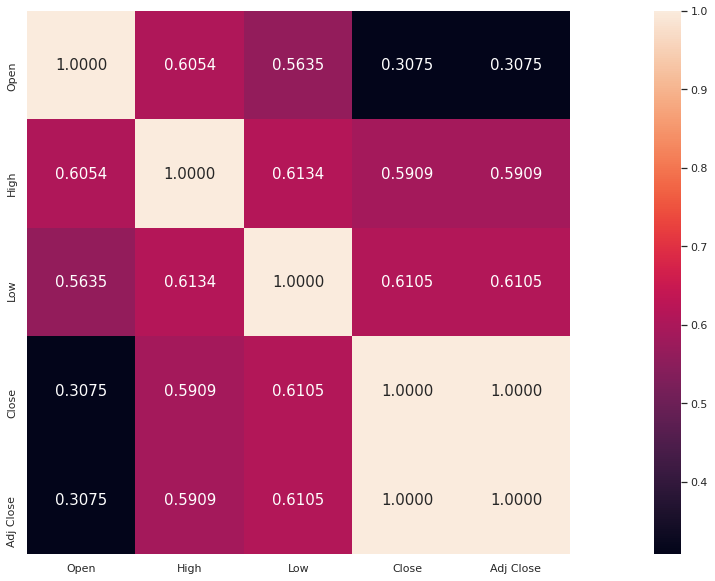

In [2062]:
import seaborn as sns
cm = np.corrcoef(train_set.T)   
sns.set(font_scale=1)   
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.4f',annot_kws={'size': 15},yticklabels=train_set.columns,xticklabels=train_set.columns)
#plt.tight_layout()
# plt.savefig('./figures/corr_mat.png', dpi=300)


In [2063]:
#test_set = pd.read_csv('test_set.csv',parse_dates= ['Date'])
test_set = 'https://raw.githubusercontent.com/oliverwsd/LSTM_AE/master/test_set.csv'
test_set = pd.read_csv(test_set,parse_dates= ['Date'])

In [2064]:
test_set.index = test_set['Date']
test_set = test_set.drop(['Date'],axis=1)

In [2065]:
# test_set = (test_set.pct_change().dropna())**2
test_set = abs(test_set.pct_change().dropna())

#  preprocessing data

In [2066]:
sc = MinMaxScaler(feature_range = (0,1))
train_set_scaled = sc.fit_transform(train_set)
test_set_scaled = sc.fit_transform(test_set)

In [2067]:
train_set_scaled = pd.DataFrame(train_set_scaled,columns=train_set.columns)

In [2068]:
test_set_scaled = pd.DataFrame(test_set_scaled,columns=train_set.columns)

In [2069]:
# preparing data for LSTM-AE
# we consider an embedding layer instead of feeding the entire seires into the model at once
# therefore we split data into smaller peices in an constant window to create a smaller seires of observertion for prediction

def normalize_data(X, Y, LOOKBACK_WINDOW):
    _X = X.dropna()
    _Xs = []
    _Ys = []
    for i in range(_X.shape[0] - LOOKBACK_WINDOW):
        cur_X = _X.values[i:i + LOOKBACK_WINDOW]
        _Xs.append(cur_X)
        
        y_pointer = i + LOOKBACK_WINDOW
        cur_Y = Y.values[y_pointer]
        _Ys.append(cur_Y)
    return np.array(_Xs), np.array(_Ys)

In [2070]:
#x_train, y_train = normalize_data(train_set_scaled, train_set_scaled['Adj Close'], 23)
#x_test, y_test = normalize_data(test_set_scaled, test_set_scaled['Adj Close'], 23)

In [2071]:
#x_train, y_train = normalize_data(train_set_scaled, train_set_scaled['Adj Close'], 10)
#x_test, y_test = normalize_data(test_set_scaled, test_set_scaled['Adj Close'], 10)

In [2072]:
x_train, y_train = normalize_data(train_set, train_set['Adj Close'],10)
x_test, y_test = normalize_data(test_set, test_set['Adj Close'],10)

In [2073]:
y_train = y_train.reshape(y_train.shape[0],1)

# Reconstruct-Model

###  We use LSTM-AE to reconstruct the market index 
the encoder is supposed to extract the hidden feature from the input data, hence helps us to reduce the data dimension

In [2074]:
timesteps = x_train.shape[1]
n_features = x_train.shape[2]

In [2075]:
model = Sequential()

model.add(LSTM(128,input_shape= (timesteps,n_features),return_sequences = True))
model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(1))

model.add(RepeatVector(timesteps))

model.add(LSTM(32, return_sequences = True))
#model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(LSTM(128,return_sequences = True))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(n_features)))

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_325 (LSTM)              (None, 10, 128)           68608     
_________________________________________________________________
batch_normalization_84 (Batc (None, 10, 128)           512       
_________________________________________________________________
dropout_280 (Dropout)        (None, 10, 128)           0         
_________________________________________________________________
lstm_326 (LSTM)              (None, 10, 32)            20608     
_________________________________________________________________
dropout_281 (Dropout)        (None, 10, 32)            0         
_________________________________________________________________
lstm_327 (LSTM)              (None, 1)                 136       
_________________________________________________________________
repeat_vector_43 (RepeatVect (None, 10, 1)           

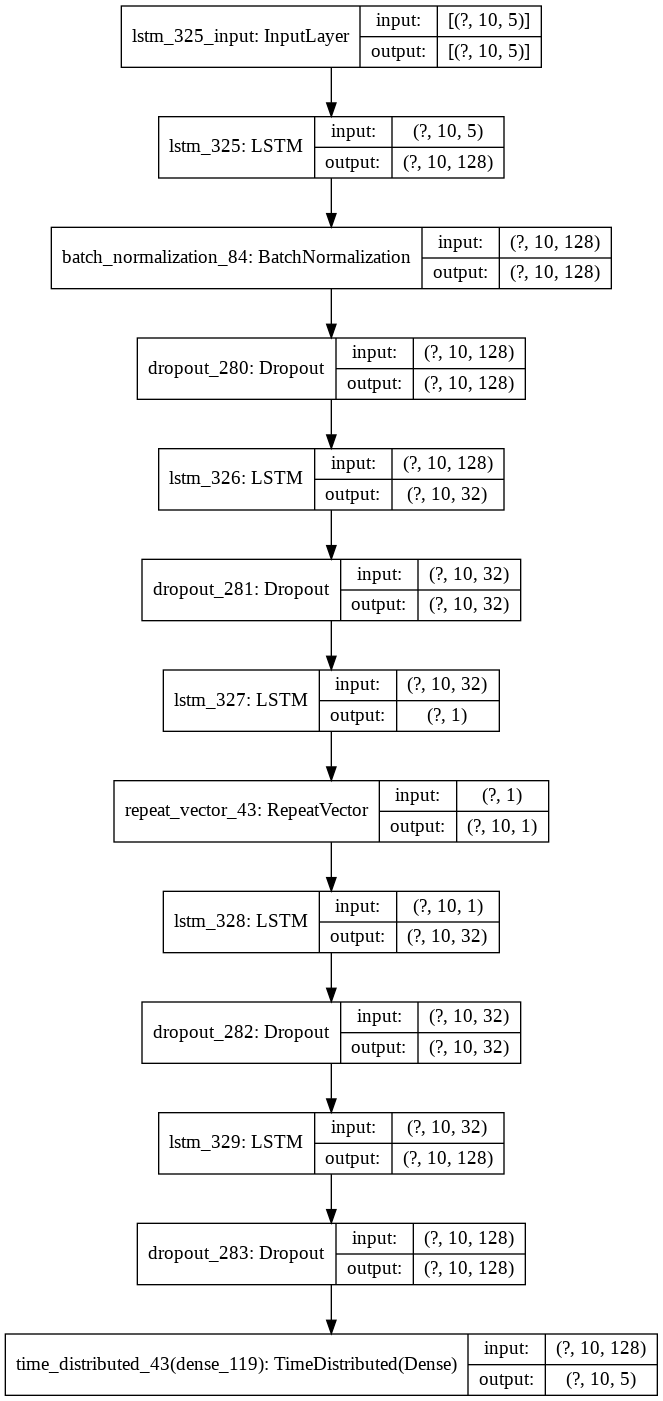

In [2076]:
from keras.models import  Model
from keras.utils import plot_model
encoder = Model(inputs=model.inputs, outputs=model.layers[5].output)
plot_model(model, show_shapes=True, to_file='encoder_decoder_reconstruct_lstm.png')

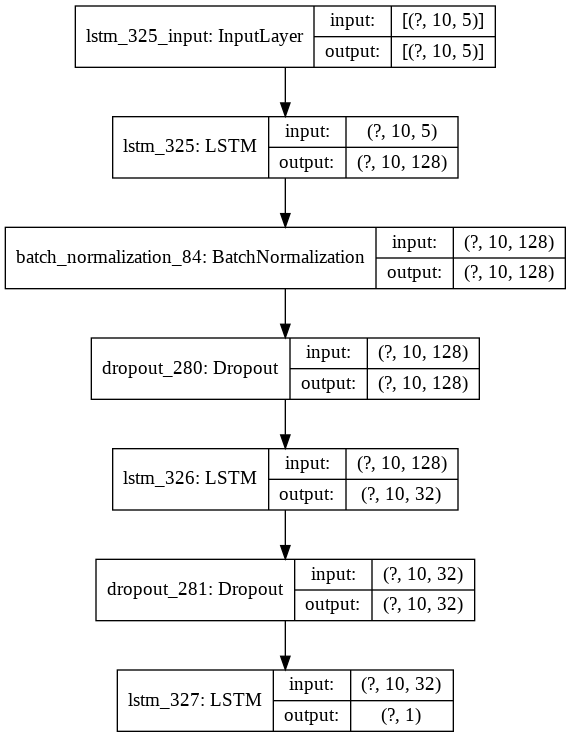

In [2077]:
plot_model(encoder, show_shapes=True, to_file='encoder_lstm.png')

In [2078]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10) # EarlyStopping
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [2079]:
history_1 = model.fit(x_train, x_train, epochs= 200, batch_size=32, validation_split=0.1, callbacks=[es], verbose=1)
# history_1 = model.fit(x_train, x_train, epochs=500, batch_size=32, validation_split = 0.1, verbose=1) #without earlystopping

Epoch 1/200
26/26 [==============================] - 3s 111ms/step - loss: 3.3682e-05 - val_loss: 2.8199e-05
Epoch 2/200
26/26 [==============================] - 1s 39ms/step - loss: 2.6945e-05 - val_loss: 2.7886e-05
Epoch 3/200
26/26 [==============================] - 1s 39ms/step - loss: 2.5737e-05 - val_loss: 2.7620e-05
Epoch 4/200
26/26 [==============================] - 1s 38ms/step - loss: 2.5038e-05 - val_loss: 2.7347e-05
Epoch 5/200
26/26 [==============================] - 1s 38ms/step - loss: 2.4914e-05 - val_loss: 2.7587e-05
Epoch 6/200
26/26 [==============================] - 1s 39ms/step - loss: 2.4847e-05 - val_loss: 2.8495e-05
Epoch 7/200
26/26 [==============================] - 1s 39ms/step - loss: 2.4751e-05 - val_loss: 2.7429e-05
Epoch 8/200
26/26 [==============================] - 1s 39ms/step - loss: 2.4308e-05 - val_loss: 2.7137e-05
Epoch 9/200
26/26 [==============================] - 1s 39ms/step - loss: 2.3860e-05 - val_loss: 2.6801e-05
Epoch 10/200
26/26 [=======

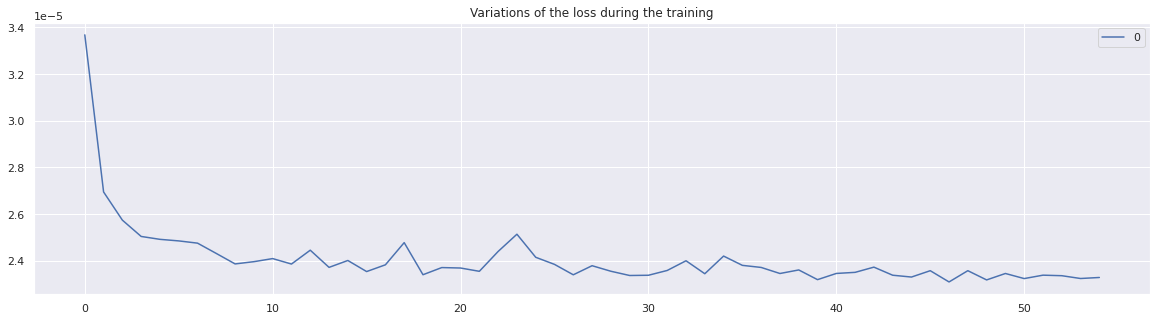

In [2080]:
pd.DataFrame(history_1.history['loss']).plot(figsize=(20,5))
plt.grid(True)
plt.title('Variations of the loss during the training')
plt.show()

In [2081]:
model.evaluate(x_test, x_test, verbose=1)

6/6 [==============================] - 0s 9ms/step - loss: 1.6304e-04


0.0001630442129680887

In [2082]:
test_prediction = model.predict(x_test)

In [2083]:
# compare mse between prediciton and target
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [2084]:
rmse(test_prediction, x_test)

0.01276887686486289

# Encoder-Model

In [2085]:
train_encoded = encoder.predict(x_train)
test_encoded = encoder.predict(x_test)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

Encoded time-series shape (907, 1)
Encoded time-series sample [0.20760643]


In [2086]:
train_encoded.shape

(907, 1)

In [2209]:
train_set_scaled.iloc[10:,:].shape

(907, 5)

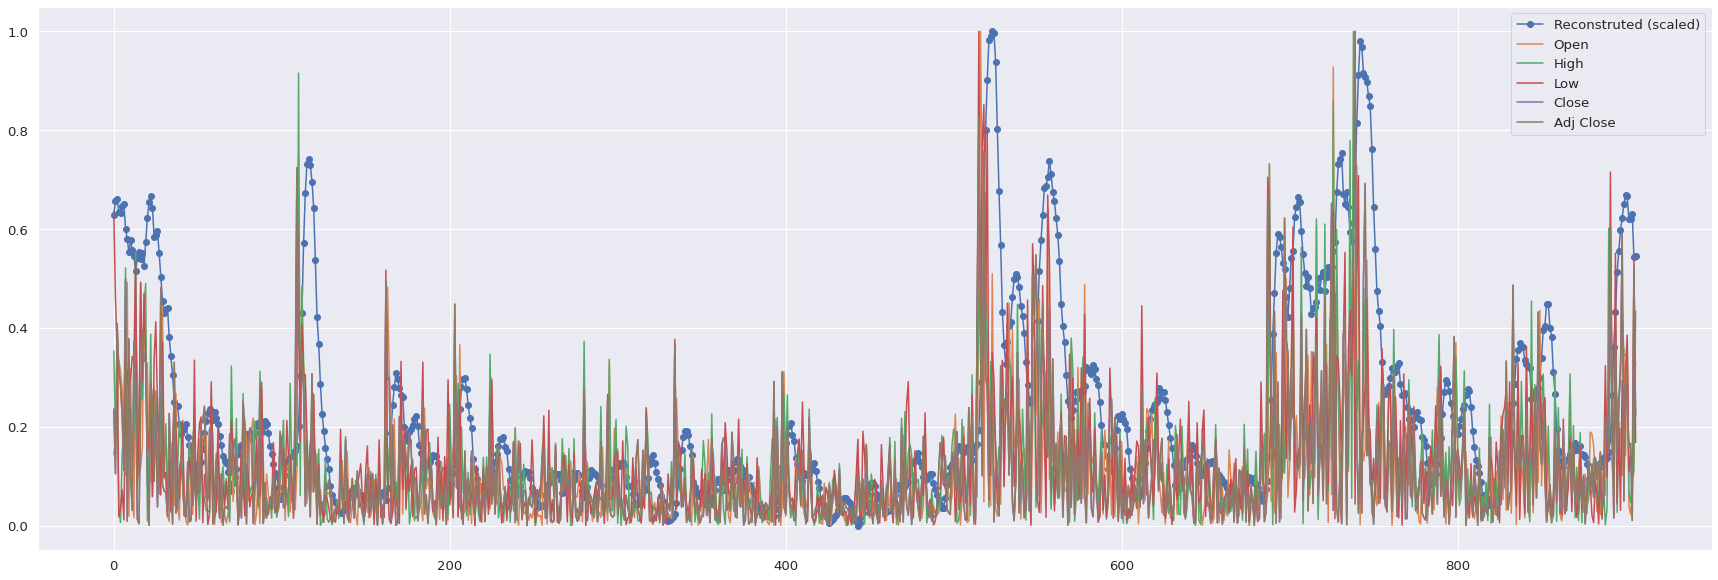

In [2218]:
train_encoded_scaled = sc.fit_transform(train_encoded)
plt.plot(train_encoded_scaled,label='Reconstruted (scaled)',marker='o')
#plt.plot(train_encoded, label='Reconstructed', marker = 'o')

for i in range(5):
  plt.plot(train_set_scaled.iloc[:,i].values[10:], label=train_set_scaled.columns[i])
plt.legend()

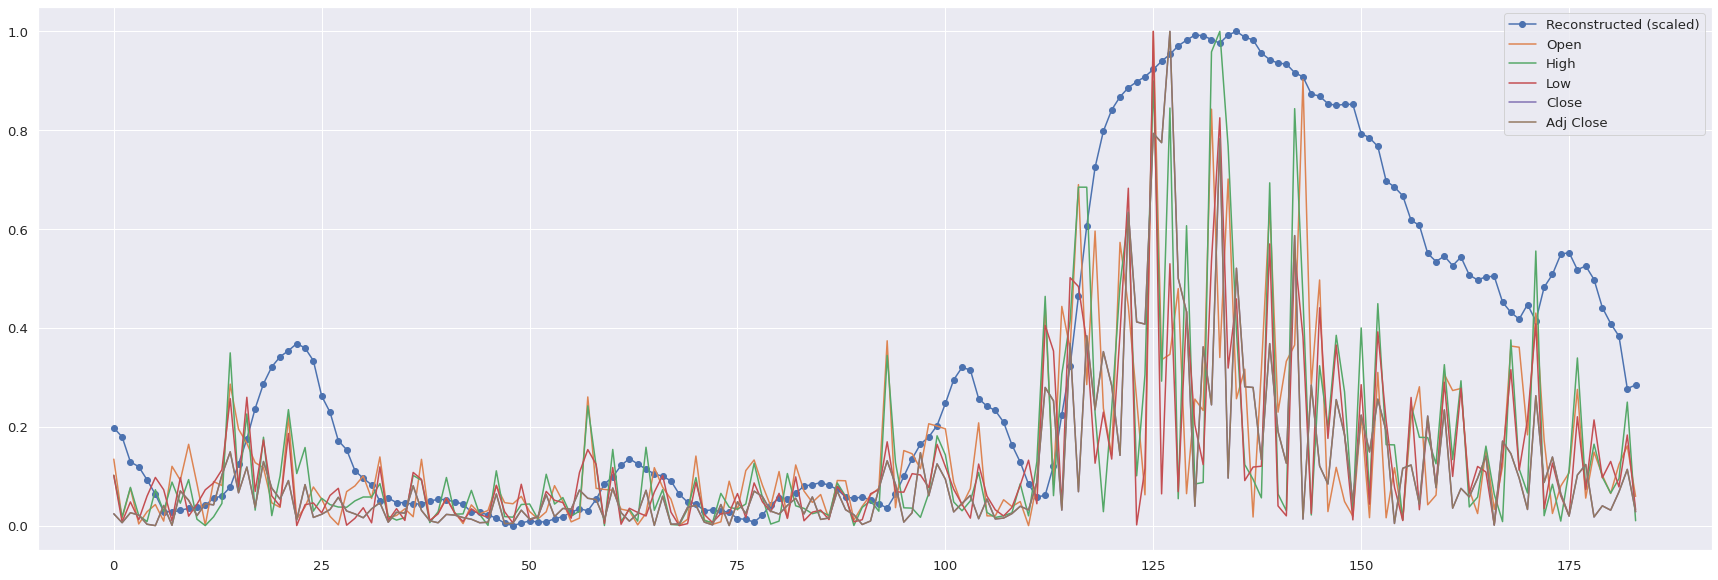

In [2222]:
test_encoded_scaled = sc.fit_transform(test_encoded)
plt.plot(test_encoded_scaled, label='Reconstructed (scaled)',marker='o')
#plt.plot(test_encoded, label='Reconstructed', marker='o')
for i in range(5):
  plt.plot(test_set_scaled.iloc[:,i].values[10:],label=test_set_scaled.columns[i])
plt.legend()

# Prediction-Model 

## Using compressed features from encoder to predict the future index

In [2140]:
#x1_train, y1_train = normalize_data(train_set_scaled['Adj Close'], train_set_scaled['Adj Close'], 23)
#x1_test, y1_test = normalize_data(test_set_scaled['Adj Close'], test_set_scaled['Adj Close'], 23)

In [2231]:
#x1_train, y1_train = normalize_data(train_set_scaled['Adj Close'], train_set_scaled['Adj Close'], 10)
#x1_test, y1_test = normalize_data(test_set_scaled['Adj Close'], test_set_scaled['Adj Close'], 10)

x1_train, y1_train = normalize_data(train_set['Adj Close'], train_set['Adj Close'],10)
x1_test, y1_test = normalize_data(test_set['Adj Close'], test_set['Adj Close'],10)

In [2232]:
x5_train, y5_train = normalize_data(train_set['Close'], train_set['Close'],10)
x5_test, y5_test = normalize_data(test_set['Close'], test_set['Close'],10)

x2_train, y2_train = normalize_data(train_set['Open'],  train_set['Open'], 10)
x2_test, y2_test = normalize_data(test_set['Open'], test_set['Open'],10)

x4_train, y4_train = normalize_data(train_set['Low'], train_set['Low'], 10)
x4_test, y4_test = normalize_data(test_set['Low'], test_set['Low'], 10)

x3_train, y3_train = normalize_data(train_set['High'], train_set['High'],10)
x3_test, y3_test = normalize_data(test_set['High'], test_set['High'], 10)

In [2144]:
def get_encoded(train, encoder,target):
  train = train.reshape(train.shape[0], train.shape[1])
  compressed_train = pd.DataFrame(train, columns = range(1,11))
  compressed_train['encoder'] = encoder
  compressed_train['target'] = target
  compressed_train.head()
  x = np.array(compressed_train[['encoder',10,9,8,7]])
  y = np.array(compressed_train[['target']])
  return x,y

In [2145]:
x2_train_encoded, y2_train_encoded = get_encoded(x2_train, train_encoded, y2_train)
x3_train_encoded, y3_train_encoded = get_encoded(x3_train, train_encoded, y3_train)
x4_train_encoded, y4_train_encoded = get_encoded(x4_train, train_encoded, y4_train)
x5_train_encoded, y5_train_encoded = get_encoded(x5_train, train_encoded, y5_train)

x2_test_encoded, y2_test_encoded = get_encoded(x2_test, test_encoded, y2_test)
x3_test_encoded, y3_test_encoded = get_encoded(x3_test, test_encoded, y3_test)
x4_test_encoded, y4_test_encoded = get_encoded(x4_test, test_encoded, y4_test)
x5_test_encoded, y5_test_encoded = get_encoded(x5_test, test_encoded, y5_test)

In [2233]:
# train data 
x1_train = x1_train.reshape(x1_train.shape[0],x1_train.shape[1])
#compressed_train = pd.DataFrame(x1_train, columns= range(1,24))
compressed_train = pd.DataFrame(x1_train, columns= range(1,11))
#compressed_train['encoder'] = train_encoded_scaled
compressed_train['encoder'] = train_encoded
compressed_train['target']= y1_train

In [2235]:
# Train data
x_train_encoded = np.array(compressed_train[['encoder',10,9,8,7]])
#x_train_encoded = np.array(compressed_train[['encoder',23,22,21,20]])
#x_train_encoded_2 = np.array(compressed_train[['encoder',22,20,18,16]])
y_train_encoded = np.array(compressed_train['target'])

x_train_encoded = x_train_encoded.reshape(x_train_encoded.shape[0],x_train_encoded.shape[1],1)
#x_train_encoded_2 = x_train_encoded_2.reshape(x_train_encoded_2.shape[0],x_train_encoded_2.shape[1],1)

In [2236]:
# test data 
x1_test = x1_test.reshape(x1_test.shape[0],x1_test.shape[1])
# compressed_test = pd.DataFrame(x1_test, columns= range(1,24))
compressed_test = pd.DataFrame(x1_test, columns= range(1,11))
compressed_test['encoder'] = test_encoded
compressed_test['target']= y1_test

x_test_encoded = np.array(compressed_test[['encoder',10,9,8,7]])
#x_test_encoded = np.array(compressed_test[['encoder',23,22,21,20]])
#x_test_encoded_2 = np.array(compressed_test[['encoder',22,20,18,16]])
y_test_encoded = np.array(compressed_test['target'])
x_test_encoded = x_test_encoded.reshape(x_test_encoded.shape[0],x_test_encoded.shape[1],1)
#x_test_encoded_2 = x_test_encoded_2.reshape(x_test_encoded_2.shape[0],x_test_encoded_2.shape[1],1)

In [2237]:
x_test_encoded.shape

(184, 5, 1)

In [2101]:
# LSTM-AE
timesteps = x_train_encoded.shape[1]
n_features = x_train_encoded.shape[2]

model2 = Sequential()
model2.add(LSTM(128,input_shape= (timesteps,n_features),return_sequences = True))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(LSTM(32, return_sequences = False))
model2.add(Dropout(0.2))
model2.add(Dense(10,activation='tanh'))
model2.add(Dense(5,activation='tanh'))
model2.add(Dense(1,activation='linear'))

model2.compile(optimizer='adam',loss='mse')
model2.summary()

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_330 (LSTM)              (None, 5, 128)            66560     
_________________________________________________________________
batch_normalization_85 (Batc (None, 5, 128)            512       
_________________________________________________________________
dropout_284 (Dropout)        (None, 5, 128)            0         
_________________________________________________________________
lstm_331 (LSTM)              (None, 32)                20608     
_________________________________________________________________
dropout_285 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 10)                330       
_________________________________________________________________
dense_121 (Dense)            (None, 5)               

In [2102]:
history_2 = model2.fit(x_train_encoded, y_train_encoded, epochs=50, batch_size= 10, validation_split=0.1, callbacks=[es], verbose=1)

#history_2 = model2.fit(x_train_encoded, y_train_encoded, epochs=100, batch_size = 32, validation_split=0.1, verbose=1)

Epoch 1/50
82/82 [==============================] - 2s 20ms/step - loss: 4.1945e-04 - val_loss: 3.9047e-05
Epoch 2/50
82/82 [==============================] - 1s 10ms/step - loss: 1.0276e-04 - val_loss: 4.2404e-05
Epoch 3/50
82/82 [==============================] - 1s 10ms/step - loss: 6.7703e-05 - val_loss: 3.8358e-05
Epoch 4/50
82/82 [==============================] - 1s 10ms/step - loss: 5.9456e-05 - val_loss: 3.6245e-05
Epoch 5/50
82/82 [==============================] - 1s 10ms/step - loss: 5.7144e-05 - val_loss: 3.6631e-05
Epoch 6/50
82/82 [==============================] - 1s 10ms/step - loss: 5.2467e-05 - val_loss: 3.8416e-05
Epoch 7/50
82/82 [==============================] - 1s 10ms/step - loss: 4.6303e-05 - val_loss: 7.0069e-05
Epoch 8/50
82/82 [==============================] - 1s 10ms/step - loss: 4.3418e-05 - val_loss: 4.6969e-05
Epoch 9/50
82/82 [==============================] - 1s 10ms/step - loss: 4.3272e-05 - val_loss: 6.2369e-05
Epoch 10/50
82/82 [==================

In [2103]:
max(y_test_encoded)

0.11984055248695669

In [2149]:
x_test_encoded[0].shape

(5, 1)

Text(0.5, 1.0, 'Model Performance (out-of-sample)')

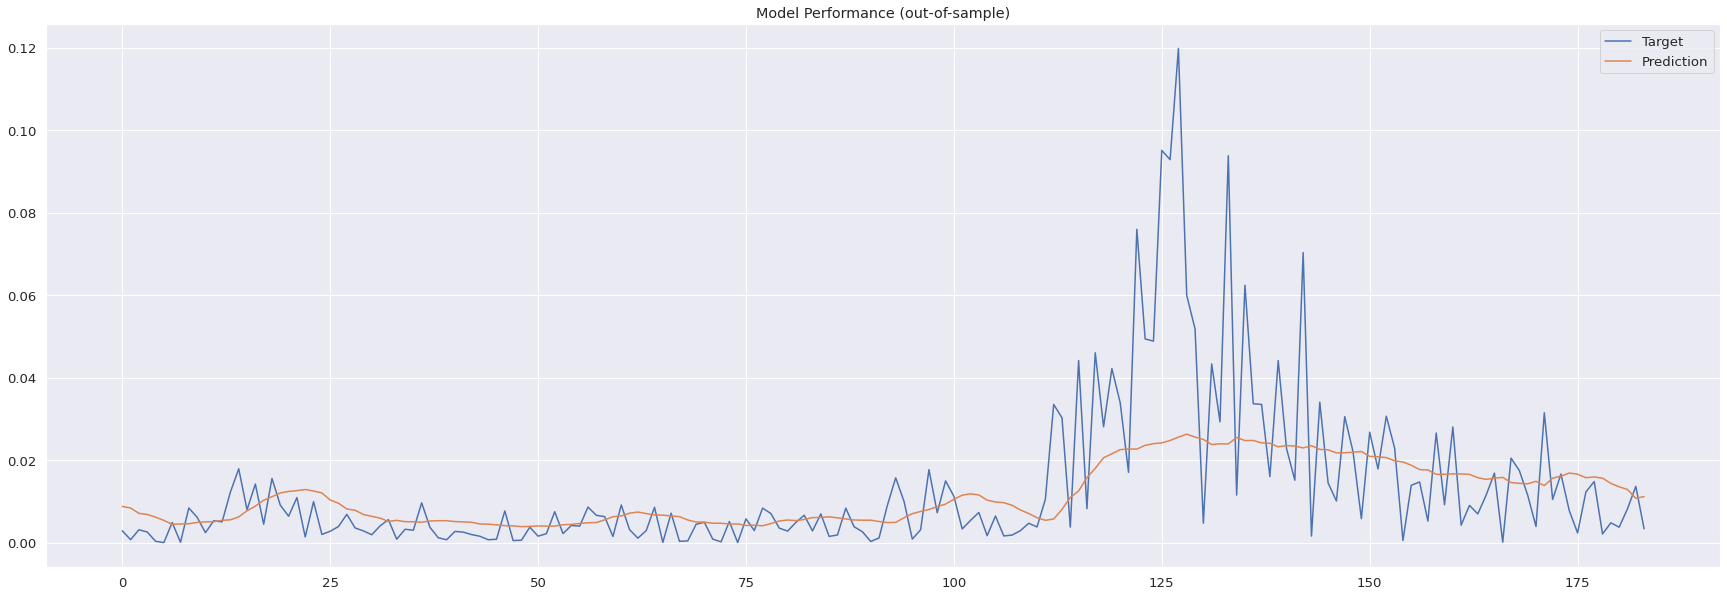

In [2152]:
test_prediction  = model2.predict(x_test_encoded)
plt.plot(y_test_encoded, label='Target')
plt.plot(test_prediction, label='Prediction')
plt.legend()
plt.title("Model Performance (out-of-sample)")

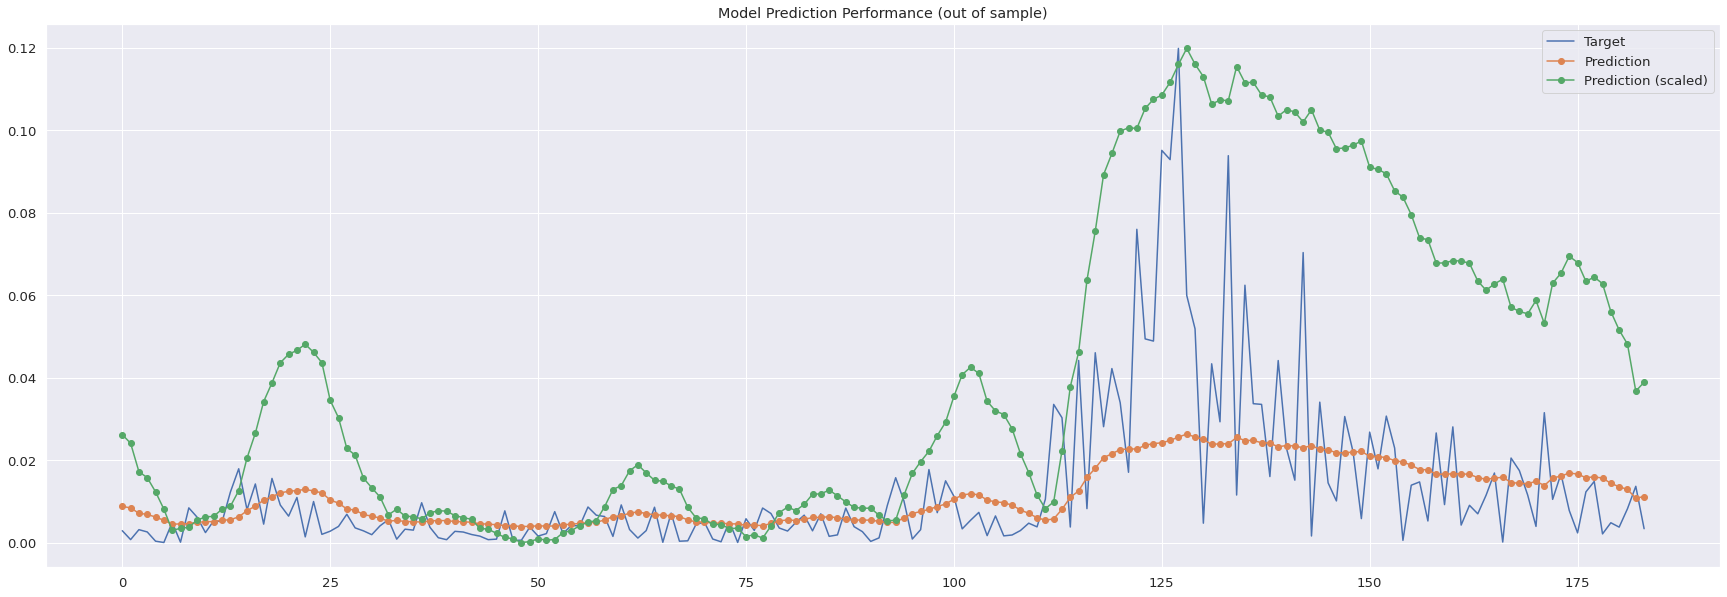

In [2243]:
test_prediction = model2.predict(x_test_encoded)
plt.plot((y_test_encoded.reshape(-1,1)),label='Target')
#plt.plot(sc.fit_transform(y_test_encoded.reshape(-1,1)),label='Target (scaled)')

sc2 = MinMaxScaler(feature_range=(0,max(y_test_encoded)))
plt.plot(test_prediction,label='Prediction', marker='o')
#plt.plot(sc.fit_transform(test_prediction),label='Prediction(scaled)',marker='o')
plt.plot(sc2.fit_transform(test_prediction),label='Prediction (scaled)', marker='o')

plt.title('Model Prediction Performance (out of sample)')
plt.legend()

In [2153]:
df = pd.DataFrame()
df['target'] = abs(y_test_encoded)
#df['prediction'] = sc2.fit_transform(test_prediction)
df['prediction'] = test_prediction
#df['encoder'] = test_encoded

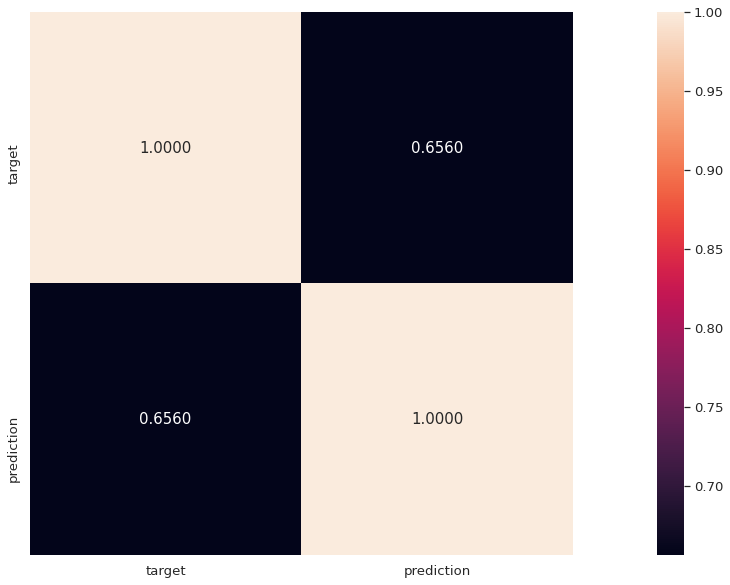

In [2154]:
cm = np.corrcoef(df.values.T)   
sns.set(font_scale=1.2)  
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.4f',annot_kws={'size': 15},yticklabels=df.columns,xticklabels=df.columns)
#plt.tight_layout()
plt.savefig('corr_mat.png', dpi=300)

# Prediction-Model 2
## Out-of-Sample

In [2226]:
#x_test, y_test = normalize_data(test_set_scaled, test_set_scaled['Adj Close'], 23)
#x_test_encoded = np.array(compressed_test[['encoder',23,22,21,20]])

#x_test, y_test = normalize_data(test_set_scaled, test_set_scaled['Adj Close'], 10)

x_test, y_test = normalize_data(test_set, test_set['Adj Close'],10)

x_test_encoded = np.array(compressed_test[['encoder',10,9,8,7]])

In [2227]:
pred1 = []
pred2 = []
pred3 = []
pred4 = []
pred5 = []

# Adj close
test1 = x_test_encoded[0].reshape(1,x_train_encoded.shape[1],x_train_encoded.shape[2])
test_prediction1 = model2.predict(test1)
pred1.append(test_prediction1)
# Open
test2 = x2_test_encoded[0].reshape(1,x_train_encoded.shape[1], x_train_encoded.shape[2])
test_prediction2 = model2.predict(test2)
pred2.append(test_prediction2)
# High
test3 = x3_test_encoded[0].reshape(1,x_train_encoded.shape[1], x_train_encoded.shape[2])
test_prediction3 = model2.predict(test3)
pred3.append(test_prediction3)
# Low
test4 = x4_test_encoded[0].reshape(1,x_train_encoded.shape[1], x_train_encoded.shape[2])
test_prediction4 = model2.predict(test4)
pred4.append(test_prediction4)
# Close
test5 = x5_test_encoded[0].reshape(1,x_train_encoded.shape[1], x_train_encoded.shape[2])
test_prediction5 = model2.predict(test5)
pred5.append(test_prediction5)

In [2228]:
_pred = []
for i in range(len(x_test_encoded)):
  test = x_test_encoded.copy()
  test[i,0] = encoder.predict(x_test[i].reshape(1,x_test.shape[1],x_test.shape[2]))
  prediction = model2.predict(test[i].reshape(1,-1,1))
  _pred.append(prediction)

_pred = pd.DataFrame(np.array(_pred).reshape(len(_pred)))

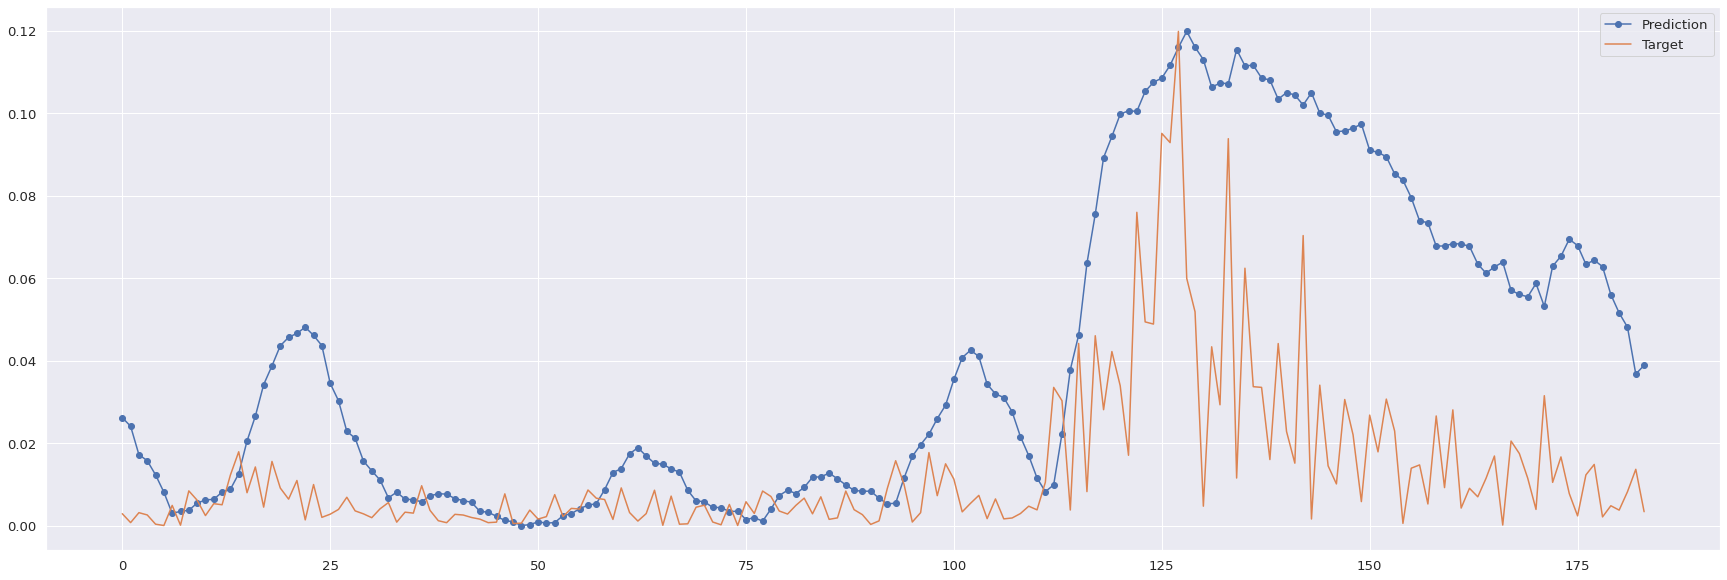

In [2229]:
plt.plot(sc2.fit_transform(_pred), label='Prediction',marker='o')
plt.plot(y_test_encoded, label='Target')
plt.legend()

In [2113]:
#test1[0,4]= test1[0,3]
#test1[0,3]= test1[0,2]
#test1[0,2]= test1[0,1]
#test1[0,1]= pred1[-1]
#x_test[1,9] = [pred2[-1],pred3[-1],pred4[-1],pred5[-1],pred1[-1]]
#encoder_value = encoder.predict(x_test[1].reshape(1,x_test.shape[1],x_test.shape[2]))
#encoder_value = sc.fit_transform(encoder_value)
#test[0,0]= encoder_value
#test_prediction = model2.predict(test)
#pred.append(test_prediction)

In [2114]:
#for i in range(1,len(x_test_encoded)):
#    #test = x_test_encoded[i].reshape(1,x_train_encoded.shape[1],x_train_encoded.shape[2])
#    test[0,4]= test[0,3]
#    test[0,3]= test[0,2]
#    test[0,2]= test[0,1]
 #   test[0,1]= pred1[-1]
 #   x_test[i,9] = [pred[-1],pred[-1],pred[-1],pred[-1],pred[-1]]
 #   encoder_value = encoder.predict(x_test[i].reshape(1,x_test.shape[1],x_test.shape[2]))  
 #   test[0,0]= encoder_value
  #  test_prediction = model2.predict(test)
  #  pred.append(test_prediction)
    
#array_pred = np.array(pred)
#df_pred = pd.DataFrame(array_pred.reshape(len(pred)))

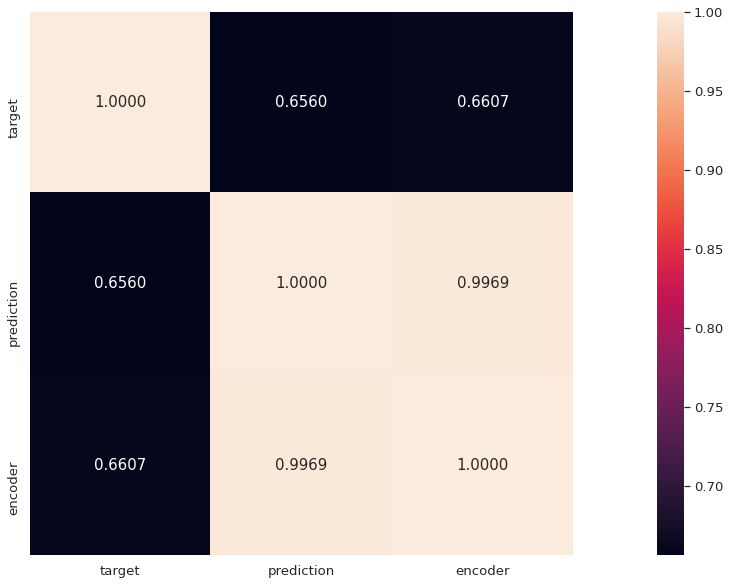

In [2115]:
df3 = pd.DataFrame()
df3['target'] = y_test_encoded
df3['prediction'] = sc2.fit_transform(_pred)
df3['encoder'] = test_encoded

#cm = np.corrcoef(df3.values.T)   
#sns.set(font_scale=1.2)  
#hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.4f',annot_kws={'size': 15},yticklabels=df3.columns,xticklabels=df3.columns)
#plt.tight_layout()
#plt.savefig('corr_mat.png', dpi=300)

# Improved Prediction-Model
## Additional features, e.g commonal stocks, least commonal stocks

In [2116]:
# inspired by the deep portfolio theory, which is capable to reconstruct the market index with limited components
# we plan to put the 5 most communal stocks into the LSTM-AE to extract the pf's hidden features from the encoder
# as well as the 5 least communal stocks to capture the market volatiles

### most communal stocks

In [2174]:
c_train_rv = 'https://raw.githubusercontent.com/oliverwsd/LSTM_AE/master/communal_rv_train.csv'
c_test_rv =  'https://raw.githubusercontent.com/oliverwsd/LSTM_AE/master/communal_rv_test.csv'

c_train_scaled = 'https://raw.githubusercontent.com/oliverwsd/LSTM_AE/master/communal_ret_train.csv'
c_test_scaled =  'https://raw.githubusercontent.com/oliverwsd/LSTM_AE/master/communal_ret_test.csv'

c_train_scaled = pd.read_csv(c_train_scaled, index_col=0)
c_train_scaled = abs(c_train_scaled)
c_test_scaled = pd.read_csv(c_test_scaled, index_col=0)
c_test_scaled = abs(c_test_scaled)

In [2175]:
#c_train_scaled = pd.read_csv('communal_train_scaled.csv',index_col=0)
#c_test_scaled =  pd.read_csv('communal_test_scaled.csv',index_col=0)

#c_x_train, c_y_train = normalize_data(c_train_scaled, train_set_scaled['Adj Close'], 23)
#c_x_test, c_y_test = normalize_data(c_test_scaled, test_set_scaled['Adj Close'], 23)

c_x_train, c_y_train = normalize_data(c_train_scaled.iloc[:-1,:], train_set['Adj Close'], 10)
c_x_test, c_y_test = normalize_data(c_test_scaled.iloc[:-1,:], test_set['Adj Close'], 10)

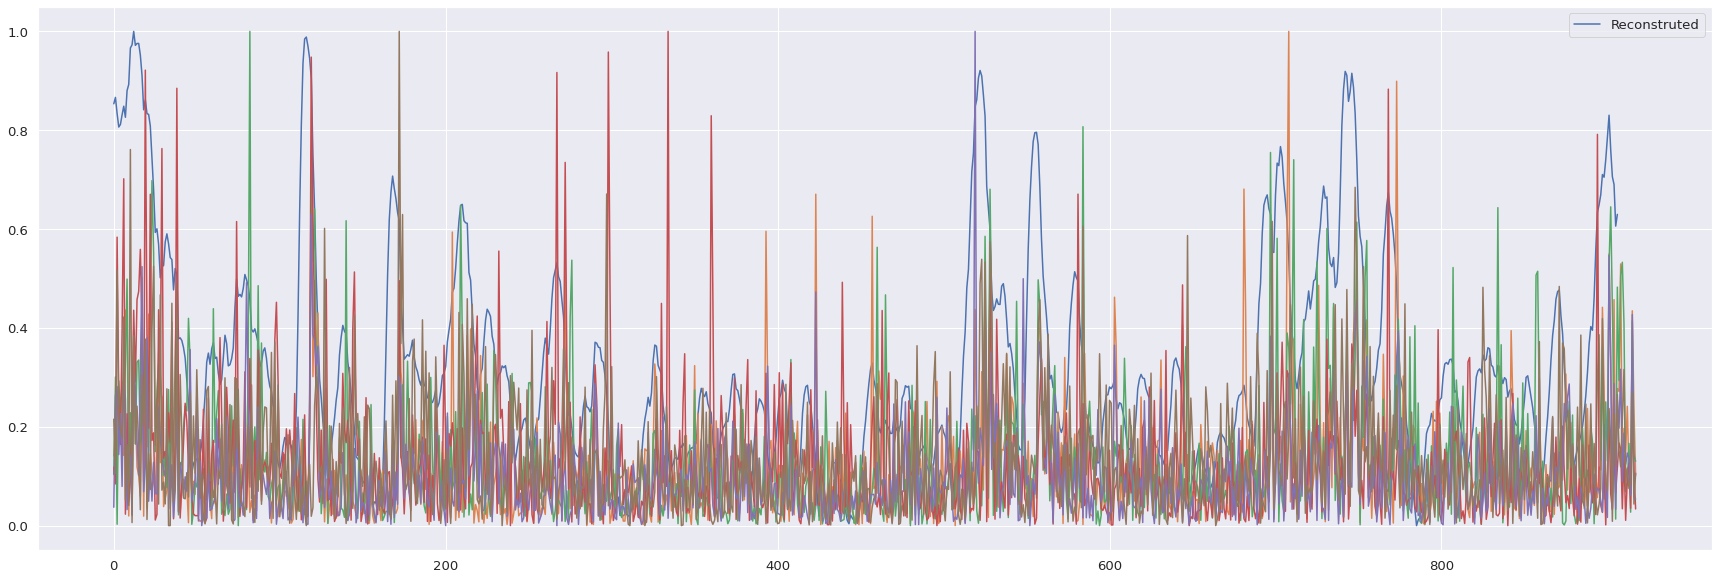

In [2181]:
c_train_encoded = encoder.predict(c_x_train)
c_train_encoded_scaled = sc.fit_transform(c_train_encoded)

plt.plot((c_train_encoded_scaled),label='Reconstruted')
#plt.plot(c_train_encoded)
plt.plot(sc.fit_transform(c_train_scaled))
#plt.plot(c_train_scaled.values)
plt.legend()

In [2194]:
c_test_scaled.head()

,MMC,FIS,CTXS,AJG,ARE
Date,,,,,
2019/8/28,0.001845,0.002048,0.003138,0.001590,0.008000
2019/8/29,0.014938,0.002336,0.006948,0.010011,0.013364
2019/8/30,0.006956,0.008083,0.002372,0.021739,0.003079
2019/9/3,0.010912,0.002569,0.000860,0.011575,0.001001
2019/9/4,0.011842,0.008420,0.002906,0.004015,0.017334


In [2196]:
c_x_test.shape

(183, 10, 5)

Text(0.5, 1.0, 'Model Performance')

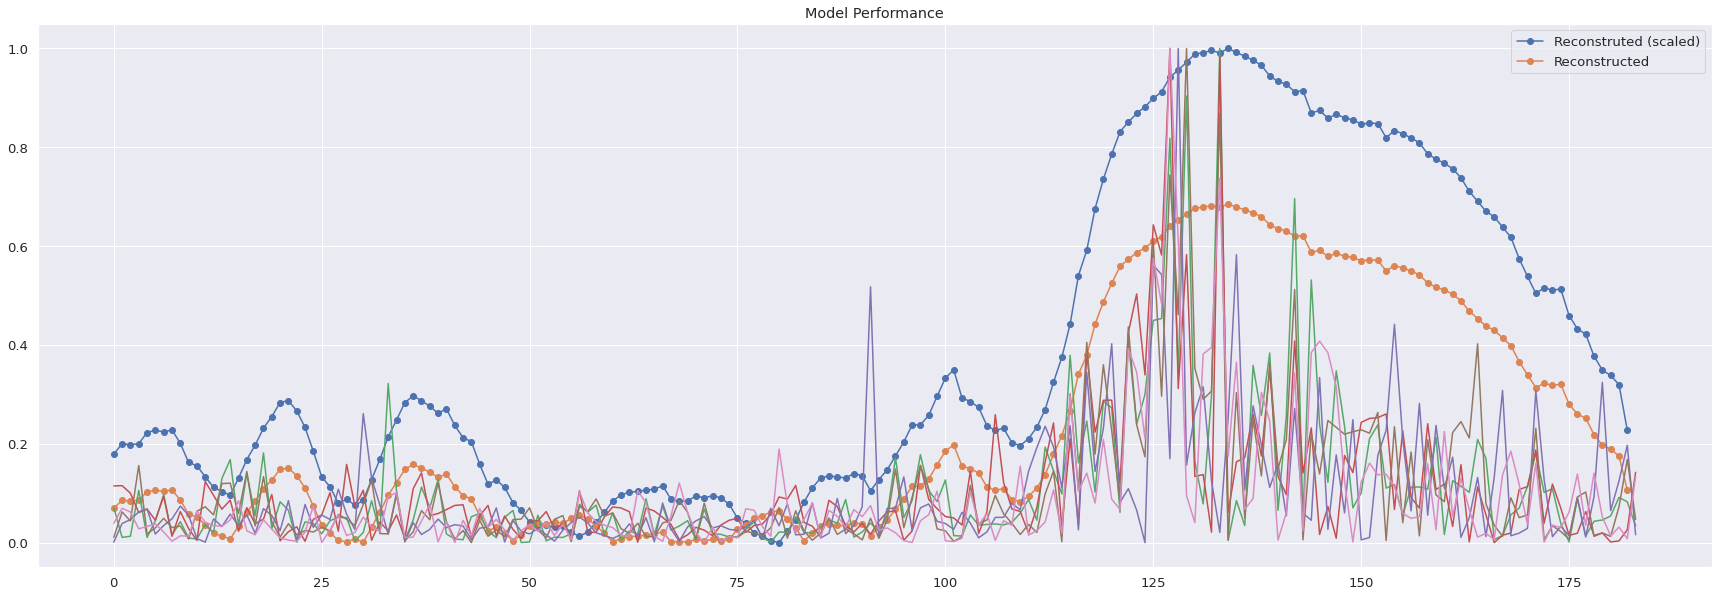

In [2198]:
c_test_encoded = encoder.predict(c_x_test)
c_test_encoded_scaled = sc.fit_transform(c_test_encoded)
plt.plot(c_test_encoded_scaled,label='Reconstruted (scaled)', marker='o')
plt.plot(abs(c_test_encoded), label='Reconstructed',marker='o')
plt.plot(sc.fit_transform(c_test_scaled[10:]))
plt.legend()
plt.title('Model Performance')

### least communal stocks

In [2122]:
l_train_scaled = 'https://raw.githubusercontent.com/oliverwsd/LSTM_AE/master/least_communal_rv_train.csv'
l_test_scaled = 'https://raw.githubusercontent.com/oliverwsd/LSTM_AE/master/least_communal_rv_test.csv'
l_train_scaled = pd.read_csv(l_train_scaled, index_col=0)
l_test_scaled = pd.read_csv(l_test_scaled, index_col=0)

In [2123]:
#l_train_scaled = pd.read_csv('least_communal_train_scaled.csv',index_col=0)
#l_test_scaled =  pd.read_csv('least_communal_test_scaled.csv',index_col=0)

#l_x_train, l_y_train = normalize_data(l_train_scaled, train_set_scaled['Adj Close'], 23)
#l_x_test, l_y_test = normalize_data(l_test_scaled, test_set_scaled['Adj Close'], 23)

l_x_train, l_y_train = normalize_data(l_train_scaled.iloc[:-1,:], train_set_scaled['Adj Close'], 10)
l_x_test, l_y_test = normalize_data(l_test_scaled.iloc[:-1,:], test_set_scaled['Adj Close'], 10)

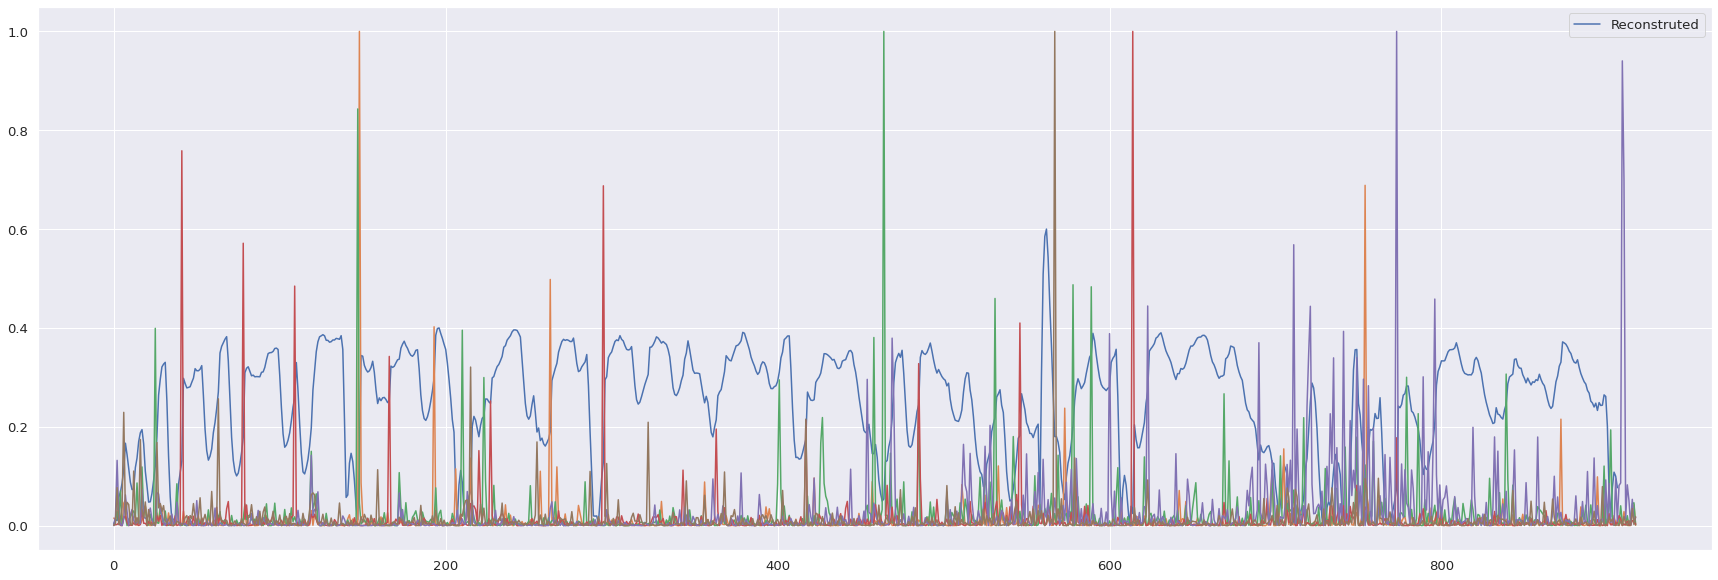

In [2124]:
l_train_encoded = encoder.predict(l_x_train)
l_train_encoded_scaled = sc.fit_transform(l_train_encoded)
plt.plot(abs(l_train_encoded_scaled-0.4),label='Reconstruted')
plt.plot(sc.fit_transform(l_train_scaled))
plt.legend()

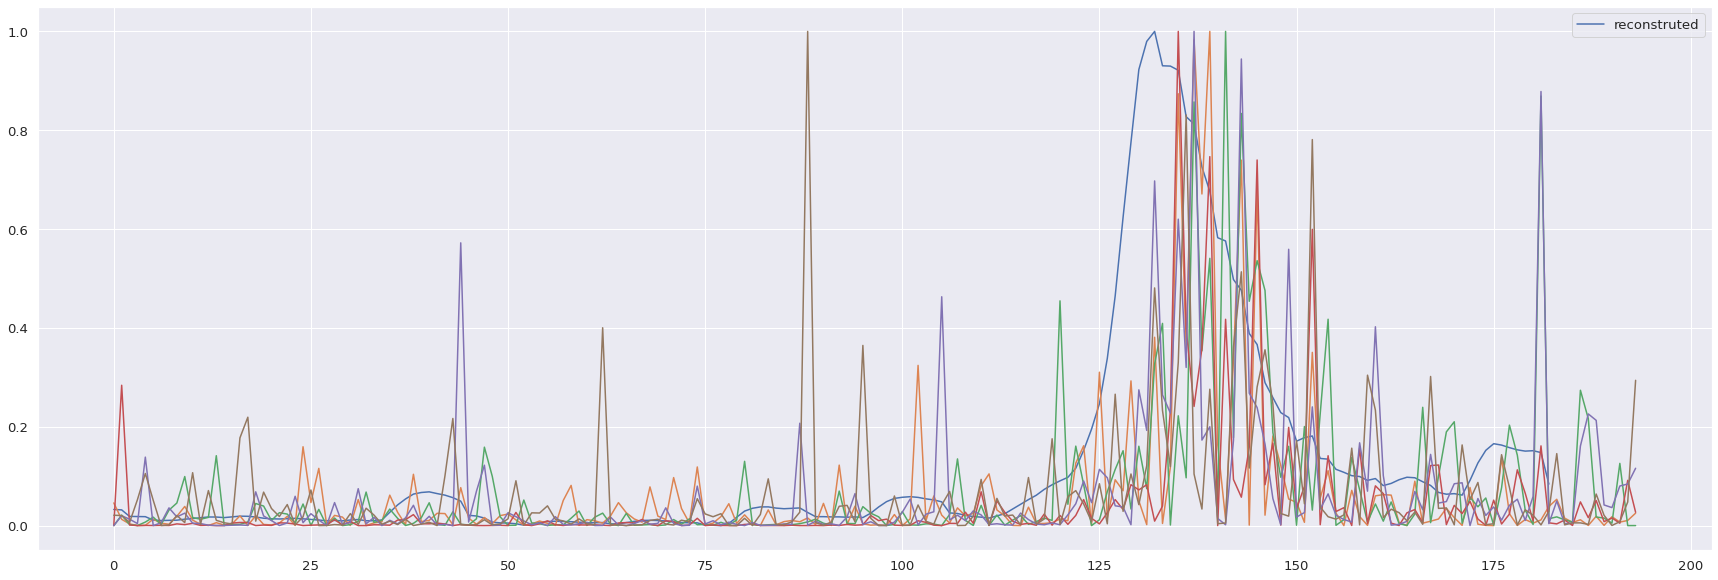

In [2125]:
l_test_encoded = encoder.predict(l_x_test)
l_test_encoded_scaled = sc.fit_transform(l_test_encoded)
plt.plot(l_test_encoded_scaled,label='reconstruted')
plt.plot(sc.fit_transform(l_test_scaled))
plt.legend()

In [2126]:
y_test_encoded.shape

(184,)

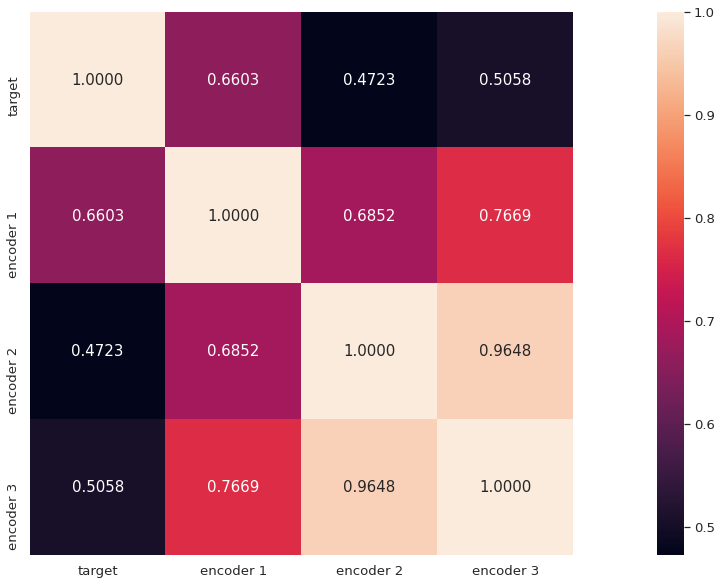

In [2127]:
df4 = pd.DataFrame()
df4['target'] = y_test_encoded[1:]
df4['encoder 1'] = test_encoded_scaled[1:]
df4['encoder 2'] = c_test_encoded_scaled
df4['encoder 3'] = l_test_encoded_scaled
cm = np.corrcoef(df4.values.T)   
sns.set(font_scale=1.2)  
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.4f',annot_kws={'size': 15},yticklabels=df4.columns,xticklabels=df4.columns)
#plt.tight_layout()
#plt.savefig('corr_mat.png', dpi=300)

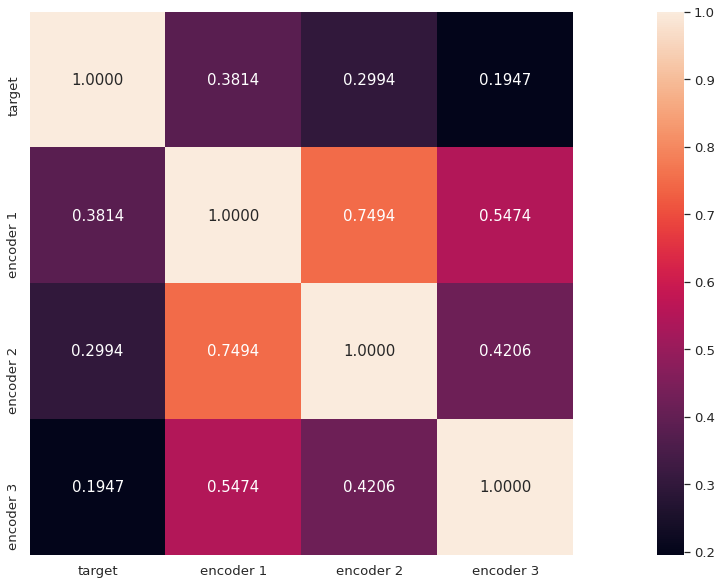

In [2128]:
df5 = pd.DataFrame()
df5['target'] = y_train_encoded
df5['encoder 1'] = train_encoded_scaled
df5['encoder 2'] = c_train_encoded_scaled
df5['encoder 3'] = l_train_encoded_scaled
cm = np.corrcoef(df5.values.T)   
sns.set(font_scale=1.2)  
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.4f',annot_kws={'size': 15},yticklabels=df5.columns,xticklabels=df5.columns)
#plt.tight_layout()
#plt.savefig('corr_mat.png', dpi=300)

Add new encoders into the model

In [2131]:
c_train_encoded.shape

(907, 1)

In [2129]:
compressed_train['c_encoder'] = c_train_encoded[:-1]
compressed_train['l_encoder'] = l_train_encoded[:-1]

#compressed_test['c_encoder'] = c_test_encoded
#compressed_test['l_encoder'] = l_test_encoded

ValueError: ignored

In [ ]:
# Train data
x_train_encoded_3 = np.array(compressed_train[['encoder',10,9,'l_encoder','c_encoder']])
#x_train_encoded_3 = np.array(compressed_train[['encoder',23,22,'l_encoder','c_encoder']])
#y_train_encoded = np.array(compressed_train['target'])
x_train_encoded_3 = x_train_encoded_3.reshape(x_train_encoded_3.shape[0],x_train_encoded_3.shape[1],1)

# Test Data
x_test_encoded_3 = np.array(compressed_test[['encoder',10,9,'l_encoder','c_encoder']])
#x_test_encoded_3 = np.array(compressed_test[['encoder',23,22,'l_encoder','c_encoder']])
#y_test_encoded = np.array(compressed_test['target'])
x_test_encoded_3 = x_test_encoded_3.reshape(x_test_encoded_3.shape[0],x_test_encoded_3.shape[1],1)

In [ ]:
history_3 = model2.fit(x_train_encoded_3, y_train_encoded, epochs=50, batch_size= 16, validation_split=0.1, callbacks=[es], verbose=1)

In [ ]:
test_prediction = model2.predict(x_test_encoded_3)
plt.plot(y_test_encoded,label='Target')
plt.plot(test_prediction,label='Prediction')
plt.title('Model Prediction Performance')
plt.legend()

In [ ]:
df6 = pd.DataFrame()
df6['target'] = y_test_encoded
df6['prediction'] = test_prediction.reshape(test_prediction.shape[0])
df6['encoder'] = test_encoded

cm = np.corrcoef(df6.values.T)   
sns.set(font_scale=1.2)  
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt='.4f',annot_kws={'size': 15},yticklabels=df6.columns,xticklabels=df6.columns)
#plt.tight_layout()
#plt.savefig('corr_mat.png', dpi=300)